### **RNN**

RNN은 순서가 있는 시계열 데이터를 처리하기 위해 고안된 신경망으로, 은닉계층을 가지고 있다. 이 은닉계층을 보통 h로 표시하는데, h<sub>t</sub>를 은닉 상태(hidden state) 혹은 은닉 상태 벡터(hidden state vector)라고 한다.

#### **BPTT**

BPTT는 RNN에서 수행하는 오차역전파로 직역하면 '시간 방향으로 펼친 신경망의 오차역전파법'이란 뜻이다. 그러나 일반적인 BPTT는 긴 시계열 데이터를 다룰 때, 문제가 발생하는데 시계열 데이터의 길이가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅 자원도 증가하기 때문이다. 또한, 시간 크기가 커지면 역전파 시의 기울기가 불안정해지는 것도 문제이다.

#### **Truncated BPTT**

Truncated BPTT는 이러한 BPTT의 문제를 해결하기 위해 고안된 것으로, 역전파의 연결을 적당한 길이로 잘라내, 잘라낸 신경망 단위로 학습을 수행한다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(grad) for grad in self.params]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

TimeRNN은 RNN을 t개 모아놓은 것으로, Truncated BPTT를 구현하기 위해 구현한 클래스이다.

In [23]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(param) for param in self.params]
    self.layers = None

    self.h, self.dh = None, None
    self.stateful = stateful

  def set_state(self, h):
    self.h = h

  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N, T, H), dtype=np.float32)

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype=np.float32)

    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)
    
    return hs

  def backward(self, hs):
    Wx, Wh, b  = self.params
    N, T, H = hs.shape
    D, H = Wx.shape

    dxs = np.empty((N, T, D), dtype=np.float32)
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(hs[:, t, :] + dh)
      dxs[:, t, :] = dx

      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh

    return dxs

### RNNLM

지금까지 RNN 모듈과, 이를 여러개 모은 TimeRNN 모듈을 만들어보았다. 이러한 모듈을 활용해 RNNLM(RNN Language Model)을 만들어 보겠다. RNNLM은 지금까지 입력된 단어를 기억하고, 그것을 바탕으로 다음에 출현할 단어를 예측한다.

먼저 시계열 데이터를 한꺼번에 처리하는 계층을 TimeEmbedding, TimeAffine 형태의 이름으로 구현해보겠다.

In [25]:
# softmax
def softmax(x):
  if x.ndim == 2:
    x -= x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))

  return x

class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    np.add.at(dW, self.idx, dout)
    return None

# TimeEmbedding
class TimeEmbedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.layers = None
    self.W = W

  def forward(self, xs):
    N, T = xs.shape
    V, D = self.W.shape

    out = np.empty((N, T, D), dtype='f')
    
    self.layers = []
    for t in range(T):
      layer = Embedding(self.W)
      out[:, t, :] = layer.forward(xs[:, t])
      self.layers.append(layer)

    return out

  def backward(self, dout):
    N, T, D = dout.shape

    grad = 0
    for t in reversed(range(T)):
      layer = self.layers[t]
      layer.backward(dout[:, t, :])
      grad += layer.grads[0]

    self.grads[0][...] = grad
    return None

# TimeAffine
class TimeAffine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.x = None

  def forward(self, x):
    N, T, D = x.shape
    W, b = self.params

    rs = x.reshape(N*T, -1)
    out = np.dot(rs, W) + b
    self.x = x
    return out.reshape(N, T, -1)

  def backward(self, dout):
    x = self.x
    N, T, D = x.shape
    W, b = self.params

    dout = dout.reshape(N*T, -1)
    rx = x.reshape(N*T, -1)

    db = np.sum(dout, axis=0)
    dW = np.dot(rx.T, dout)
    dx = np.dot(dout, W.T)
    dx = dx.reshape(*x.shape)

    self.grads[0][...] = dW
    self.grads[1][...] = db

    return dx

# TimeSoftmaxWithLoss
class TimeSoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads= [], []
    self.cache = None
    self.ignore_label = -1

  def forward(self, xs, ts):
    N, T, V = xs.shape

    # 원-핫 벡터로 라벨링 되었을 경우
    if ts.ndim == 3:
      ts = ts.argmax(axis=2)

    mask = (ts != self.ignore_label)

    xs = xs.reshape(N*T, -1)
    ts = ts.reshape(N*T)
    mask = mask.reshape(N*T)

    ys = softmax(xs)
    ls = np.log(ys[np.arange(N*T), ts])
    ls *= mask
    loss = -np.sum(ls)
    loss /= np.sum(mask)

    self.cache = (ts, ys, mask, (N, T, V))
    return loss

  def backward(self, dout=1):
    ts, ys, mask, (N, T, V) = self.cache

    dx = ys
    dx[np.arange(N*T), ts] -= 1
    dx *= dout
    dx /= mask.sum()
    dx *= mask[:, np.newaxis]
    
    dx = dx.reshape((N, T, V))
    return dx

SimpleRnnlm 클래스를 만들어서 RNNLM 신경망을 만든다.

In [14]:
class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size

    # Xavier 초기화를 사용한 가중치 초기화
    embed_W = (np.random.randn(V, D) / 100).astype(np.float32)
    rnn_Wx = (np.random.randn(D, H) / np.sqrt(D)).astype(np.float32)
    rnn_Wh = (np.random.randn(H, H) / np.sqrt(H)).astype(np.float32)

    rnn_b = np.zeros(H).astype(np.float32)
    affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)

    self.layers = [
      TimeEmbedding(embed_W),
      TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
      TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.rnn_layer.reset_state()

### 언어모델의 평가

#### 1. perplexity
언어모델의 성능은 평가할때는 보통 perplexity를 자주 이용한다.

예를들어, RNNLM 모델에 'you'를 넣으면 'say'가 나올 확률로 0.8이 계산되었다고 가정해보자. perplexity는 0.8의 역수로, 1.25가 된다.
<br><br>
이 perplexity는 분기 수(number of brahches)로 해석될 수 있는데, 직관적으로 보면 후보로 올 수 있는 단어의 개수가 'perplexity'개 만큼 있다는 것이다. 앞의 예에서는 'say'의 perplexity값이 1.25가 나왔으므로, 'you' 다음으로 나올 수 있는 강력한 후보는 1개라고 할 수 있다.

<br>

#### 2. 입력이 여러개일 때의 perplexity

만약 이번 RNNLM처럼 입력이 여러개면 다음과 같이 perplexity를 표현할 수 있다.

> L = TimeSoftmaxWithLoss().forward(xs, ts) <br>
perplexity = np.exp(L)


RNNLM으로 학습해 보자.

| 에폭 1 | 퍼플렉시티 384.30
| 에폭 2 | 퍼플렉시티 254.06
| 에폭 3 | 퍼플렉시티 221.26
| 에폭 4 | 퍼플렉시티 214.00
| 에폭 5 | 퍼플렉시티 204.88
| 에폭 6 | 퍼플렉시티 201.45
| 에폭 7 | 퍼플렉시티 198.15
| 에폭 8 | 퍼플렉시티 196.50
| 에폭 9 | 퍼플렉시티 192.13
| 에폭 10 | 퍼플렉시티 193.06
| 에폭 11 | 퍼플렉시티 189.75
| 에폭 12 | 퍼플렉시티 192.54
| 에폭 13 | 퍼플렉시티 190.44
| 에폭 14 | 퍼플렉시티 190.84
| 에폭 15 | 퍼플렉시티 190.15
| 에폭 16 | 퍼플렉시티 186.73
| 에폭 17 | 퍼플렉시티 184.09
| 에폭 18 | 퍼플렉시티 181.47
| 에폭 19 | 퍼플렉시티 183.30
| 에폭 20 | 퍼플렉시티 184.43
| 에폭 21 | 퍼플렉시티 181.69
| 에폭 22 | 퍼플렉시티 178.51
| 에폭 23 | 퍼플렉시티 175.13
| 에폭 24 | 퍼플렉시티 176.51
| 에폭 25 | 퍼플렉시티 174.04
| 에폭 26 | 퍼플렉시티 173.50
| 에폭 27 | 퍼플렉시티 167.98
| 에폭 28 | 퍼플렉시티 167.38
| 에폭 29 | 퍼플렉시티 163.95
| 에폭 30 | 퍼플렉시티 158.33
| 에폭 31 | 퍼플렉시티 159.02
| 에폭 32 | 퍼플렉시티 153.62
| 에폭 33 | 퍼플렉시티 152.76
| 에폭 34 | 퍼플렉시티 147.27
| 에폭 35 | 퍼플렉시티 146.48
| 에폭 36 | 퍼플렉시티 138.78
| 에폭 37 | 퍼플렉시티 132.59
| 에폭 38 | 퍼플렉시티 130.48
| 에폭 39 | 퍼플렉시티 124.09
| 에폭 40 | 퍼플렉시티 119.24
| 에폭 41 | 퍼플렉시티 118.30
| 에폭 42 | 퍼플렉시티 111.14
| 에폭 43 | 퍼플렉시티 105.65
| 에폭 44 | 퍼플렉시티 100.

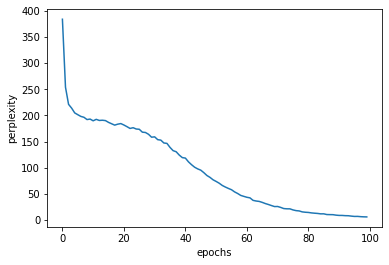

In [33]:
# optimizer
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr
        
  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]

# 학습 코드 시작
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
  for iter in range(max_iters):
    batch_x = np.empty((batch_size, time_size), dtype='i')
    batch_t = np.empty((batch_size, time_size), dtype='i')

    for t in range(time_size): 
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1

    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1

  ppl = np.exp(total_loss / loss_count)
  print('| 에폭 %d | 퍼플렉시티 %.2f' % (epoch+1, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0, 0

plt.plot(range(max_epoch), ppl_list)
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()